# Transfer Learning using VGG16 Model
The VGG16 model was proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. It is an extremely accurate image classifier with an accuracy score of 92.7% on ImageNet. This model can be accessed with Keras.

Here, we use this model in transfer learning to predict who took a given picture. This is to compare to `TransferLearning_Ours.ipynb`, in which we use the convolutional neural network *we* created using the Cal Tech 101 dataset.

In [1]:
import random
import numpy as np
import keras
import pandas as pd

Using TensorFlow backend.


In [2]:
np.random.seed(123)
random.seed(123)

# Load Data
Load the alex_hunter dataset, resizing images to 224 X 224 (dimensions of the dataset used to train the VGG16 model).

In [3]:
%run DataPreparation.ipynb

# 224 X 224 for VGG16 model
data = get_datasets(width=224, height=224, which='alex_hunter')

X_alex_hunter = data['X_alex_hunter']
y_alex_hunter = data['y_alex_hunter']

print(len(X_alex_hunter), 'Alex Hunter Pictures')

Alex Hunter Time: 0:00:03.233767
369 Alex Hunter Pictures


# Load VGG16 Model - For Comparison
Load VGG16 model from keras. Then, transform it into a sequential model wih the last layer dropped, and freeze all layers.

In [4]:
import keras
vgg16_model = keras.applications.vgg16.VGG16()

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# transform vgg16 from Model to Sequential
# also remove last layer
model = keras.Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    
# freeze all layers - exclude from future training
for layer in model.layers:
    layer.trainable = False

# Prep Data
Make sure the response variable is seen as categorical by keras. Shuffle the data and split into train test split.

In [6]:
# --- Constants -----------------------------------
test_prop = 0.3
test_split = round(test_prop*len(X_alex_hunter))
num_classes = len(set(y_alex_hunter))

# --- Shuffle Data -----------------------------------
idxs = np.array(range(len(X_alex_hunter)))
np.random.shuffle(idxs)
X_alex_hunter = X_alex_hunter[idxs]
y_alex_hunter = y_alex_hunter[idxs]

# --- Data Manipulation -----------------------------------
distinct_categories = sorted(list(set(y_alex_hunter)))
y_alex_hunter_cat = [
    distinct_categories.index(y) for y in y_alex_hunter
]
y_alex_hunter_cat = keras.utils.to_categorical(
    y_alex_hunter_cat, num_classes
)

# --- Train Test Split -----------------------------------
X_alex_hunter_test = X_alex_hunter[:test_split]
y_alex_hunter_test = y_alex_hunter_cat[:test_split]
y_alex_hunter_labels_test = y_alex_hunter[:test_split]

X_alex_hunter_train = X_alex_hunter[test_split:]
y_alex_hunter_train = y_alex_hunter_cat[test_split:]
y_alex_hunter_labels_train = y_alex_hunter[test_split:]

In [7]:
print(len(X_alex_hunter_train), 'Train (', 
      list(y_alex_hunter_labels_train).count('Hunter'), 'Hunter,', 
      list(y_alex_hunter_labels_train).count('Alex'), 'Alex )')
print(len(X_alex_hunter_test), 'Test (', 
      list(y_alex_hunter_labels_test).count('Hunter'), 'Hunter,', 
      list(y_alex_hunter_labels_test).count('Alex'), 'Alex )')

258 Train ( 132 Hunter, 126 Alex )
111 Test ( 57 Hunter, 54 Alex )


# Add to Model
Add a final dense layer (the only layer that will be trained) leading to one output node per category (in this case 2, one for Hunter and one for Alex).

In [8]:
model.add(keras.layers.Dense(
    num_classes, activation='softmax'
))

In [9]:
batch_size = 10
epochs = 5
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.SGD(
      lr=0.01, momentum=0.0, nesterov=False
    ),
#     optimizer=keras.optimizers.Adam(lr=0.0001),
    metrics=['accuracy']
)

model.fit(
    X_alex_hunter_train, y_alex_hunter_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(
        X_alex_hunter_test, y_alex_hunter_test
    )
)

Instructions for updating:
Use tf.cast instead.
Train on 258 samples, validate on 111 samples
Epoch 1/5
258/258 [==============================] - 177s 687ms/step - loss: 1.2749 - acc: 0.7907 - val_loss: 0.0577 - val_acc: 0.9910
Epoch 2/5
258/258 [==============================] - 183s 711ms/step - loss: 0.0394 - acc: 0.9961 - val_loss: 0.0402 - val_acc: 0.9910
Epoch 3/5
258/258 [==============================] - 178s 689ms/step - loss: 0.0043 - acc: 0.9961 - val_loss: 0.0537 - val_acc: 0.9910
Epoch 4/5
258/258 [==============================] - 174s 676ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0270 - val_acc: 0.9910
Epoch 5/5
258/258 [==============================] - 160s 618ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9910


Using the VGG16 model, we predicted the photographer of an image with 99.1% accuracy.

# Evaluation
Create confusion matrix

In [10]:
y_alex_hunter_labels_test[0], list(y_alex_hunter_test[0])

('Alex', [1.0, 0.0])

In [11]:
predictions = model.predict(X_alex_hunter_test)

In [12]:
def to_choice(pred):
    """
    Neural network returns a float for Hunter and a float for Alex
    This function transforms this into an actual prediction,
    based on which output's value is largest.
    
    e.g. [0.9496, 0.0504] -> [1, 0], codes for "Alex"
    """
    if pred[0] > pred[1]:
        # ALEX
        return np.array([1,0]), 'Alex'
    else:
        # HUNTER
        return np.array([0,1]), 'Hunter'
    
# outer = true, inner = predicted
confusion = {
    # of true zeros
    'Alex true': {
        # number predicted as 0
        'Alex pred':0,
        # number predicted as 1
        'Hunter pred':0
    },
    # of true ones
    'Hunter true': {
        # number predicted as 0
        'Alex pred':0,
        # number predicted as 1
        'Hunter pred':0
    }
}

correct = 0
for i in range(len(predictions)):
    pred_choice, pred_label = to_choice(predictions[i])
    true = y_alex_hunter_test[i]
    true_label = 'Alex' if true[0] == 1 else 'Hunter'
    if pred_label == true_label:
        correct += 1
    else:
        print('Incorrect:', i)
    confusion[true_label+' true'][pred_label+' pred'] += 1

print("{0}% correct".format(round(100*correct/len(predictions), 2)))
print("Confusion Matrix")
pd.DataFrame(confusion)

Incorrect: 19
99.1% correct
Confusion Matrix


,Alex true,Hunter true
Alex pred,54,1
Hunter pred,0,56


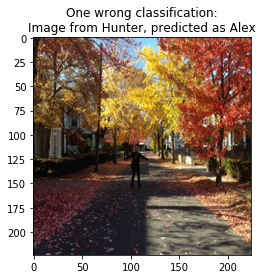

In [14]:
plt.imshow(X_alex_hunter_test[19])
plt.title("One wrong classification:\nImage from Hunter, predicted as Alex")
plt.show()